In [7]:
import itertools
import networkx as nx
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from itertools import chain
import sys
sys.path.append('/home/ziniu.wzn/BayesCard')
import pandas as pd
import time
import sys
import copy
from Models.pgmpy_BN import Pgmpy_BN

In [9]:
from Pgmpy.factors import factor_product
from Pgmpy.models import BayesianModel, JunctionTree
from Pgmpy.inference.EliminationOrder import (
    WeightedMinFill,
    MinNeighbors,
    MinFill,
    MinWeight,
)
from Pgmpy.factors.discrete import TabularCPD
class VariableElimination(object):
    def __init__(self, model):
        self.model = model
        model.check_model()

        if isinstance(model, JunctionTree):
            self.variables = set(chain(*model.nodes()))
        else:
            self.variables = model.nodes()

        self.cardinality = {}
        self.factors = defaultdict(list)

        if isinstance(model, BayesianModel):
            self.state_names_map = {}
            for node in model.nodes():
                cpd = model.get_cpds(node)
                if isinstance(cpd, TabularCPD):
                    self.cardinality[node] = cpd.variable_card
                    cpd = cpd.to_factor()
                for var in cpd.scope():
                    self.factors[var].append(cpd)
                self.state_names_map.update(cpd.no_to_name)

        elif isinstance(model, JunctionTree):
            self.cardinality = model.get_cardinality()

            for factor in model.get_factors():
                for var in factor.variables:
                    self.factors[var].append(factor)
    
    def _get_working_factors(self, evidence):
        """
        Uses the evidence given to the query methods to modify the factors before running
        the variable elimination algorithm.
        Parameters
        ----------
        evidence: dict
            Dict of the form {variable: state}
        Returns
        -------
        dict: Modified working factors.
        """

        working_factors = {
            node: {(factor, None) for factor in self.factors[node]}
            for node in self.factors
        }

        # Dealing with evidence. Reducing factors over it before VE is run.
        if evidence:
            for evidence_var in evidence:
                for factor, origin in working_factors[evidence_var]:
                    factor_reduced = factor.reduce(
                        [(evidence_var, evidence[evidence_var])], inplace=False
                    )
                    for var in factor_reduced.scope():
                        working_factors[var].remove((factor, origin))
                        working_factors[var].add((factor_reduced, evidence_var))
                if type(evidence[evidence_var]) != list:
                    del working_factors[evidence_var]
        return working_factors
    
    def _get_elimination_order(
        self, variables, evidence, elimination_order="minfill", show_progress=False
    ):
        """
        Deals with all elimination order parameters given to _variable_elimination method
        and returns a list of variables that are to be eliminated
        Parameters
        ----------
        elimination_order: str or list
        Returns
        -------
        list: A list of variables names in the order they need to be eliminated.
        """
        not_evidence_eliminate = []
        if evidence is not None:
            for key in evidence:
                if type(evidence[key]) != list:
                    not_evidence_eliminate.append(key)
        to_eliminate = (
            set(self.variables)
            - set(variables)
            - set(not_evidence_eliminate)
        )

        # Step 1: If elimination_order is a list, verify it's correct and return.
        if hasattr(elimination_order, "__iter__") and (
            not isinstance(elimination_order, str)
        ):
            if any(
                var in elimination_order
                for var in set(variables).union(
                    set(evidence.keys() if evidence else [])
                )
            ):
                raise ValueError(
                    "Elimination order contains variables which are in"
                    " variables or evidence args"
                )
            else:
                return elimination_order

        # Step 2: If elimination order is None or a Markov model, return a random order.
        elif (elimination_order is None) or (not isinstance(self.model, BayesianModel)):
            return to_eliminate

        # Step 3: If elimination order is a str, compute the order using the specified heuristic.
        elif isinstance(elimination_order, str) and isinstance(
            self.model, BayesianModel
        ):
            heuristic_dict = {
                "weightedminfill": WeightedMinFill,
                "minneighbors": MinNeighbors,
                "minweight": MinWeight,
                "minfill": MinFill,
            }
            elimination_order = heuristic_dict[elimination_order.lower()](
                self.model
            ).get_elimination_order(nodes=to_eliminate, show_progress=show_progress)
            return elimination_order
    
    def _variable_elimination(
        self,
        variables,
        operation,
        evidence=None,
        elimination_order="MinFill",
        joint=True,
        show_progress=False,
    ):
        """
        Implementation of a generalized variable elimination.

        Parameters
        ----------
        variables: list, array-like
            variables that are not to be eliminated.

        operation: str ('marginalize' | 'maximize')
            The operation to do for eliminating the variable.

        evidence: dict
            a dict key, value pair as {var: state_of_var_observed}
            None if no evidence

        elimination_order: str or list (array-like)
            If str: Heuristic to use to find the elimination order.
            If array-like: The elimination order to use.
            If None: A random elimination order is used.
        """
        # Step 1: Deal with the input arguments.
        if isinstance(variables, str):
            raise TypeError("variables must be a list of strings")
        if isinstance(evidence, str):
            raise TypeError("evidence must be a list of strings")

        # Dealing with the case when variables is not provided.
        if not variables:
            all_factors = []
            for factor_li in self.factors.values():
                all_factors.extend(factor_li)
            if joint:
                return factor_product(*set(all_factors))
            else:
                return set(all_factors)

        # Step 2: Prepare data structures to run the algorithm.
        eliminated_variables = set()
        # Get working factors and elimination order
        tic = time.time()
        working_factors = self._get_working_factors(evidence)
        toc = time.time()
        #print(f"getting working factors takes {toc-tic} secs")
        elimination_order = self._get_elimination_order(
            variables, evidence, elimination_order, show_progress=show_progress
        )
        #print(f"getting elimination orders takes {time.time()-toc} secs")
        # Step 3: Run variable elimination
        if show_progress:
            pbar = tqdm(elimination_order)
        else:
            pbar = elimination_order

        for var in pbar:
            tic = time.time()
            #print(var)
            if show_progress:
                pbar.set_description("Eliminating: {var}".format(var=var))
            # Removing all the factors containing the variables which are
            # eliminated (as all the factors should be considered only once)
            factors = [
                factor
                for factor, _ in working_factors[var]
                if not set(factor.variables).intersection(eliminated_variables)
            ]
            #print(factors)
            phi = factor_product(*factors)
            phi = getattr(phi, operation)([var], inplace=False)
            del working_factors[var]
            for variable in phi.variables:
                working_factors[variable].add((phi, var))
            eliminated_variables.add(var)
            #print(f"eliminating {var} takes {time.time()-tic} secs")
            
        # Step 4: Prepare variables to be returned.
        tic = time.time()
        final_distribution = set()
        for node in working_factors:
            for factor, origin in working_factors[node]:
                if not set(factor.variables).intersection(eliminated_variables):
                    final_distribution.add((factor, origin))
        final_distribution = [factor for factor, _ in final_distribution]
        #print(final_distribution)
        #print(f"the rest takes {time.time()-tic} secs")
        if joint:
            if isinstance(self.model, BayesianModel):
                return factor_product(*final_distribution).normalize(inplace=False)
            else:
                return factor_product(*final_distribution)
        else:
            query_var_factor = {}
            for query_var in variables:
                phi = factor_product(*final_distribution)
                query_var_factor[query_var] = phi.marginalize(
                    list(set(variables) - set([query_var])), inplace=False
                ).normalize(inplace=False)
            #print(f"the rest takes {time.time()-tic} secs")
            return query_var_factor

    def query(
        self,
        variables,
        evidence=None,
        elimination_order="MinFill",
        joint=True,
        show_progress=False,
    ):
        """
        Parameters
        ----------
        variables: list
            list of variables for which you want to compute the probability

        evidence: dict
            a dict key, value pair as {var: state_of_var_observed}
            None if no evidence

        elimination_order: list
            order of variable eliminations (if nothing is provided) order is
            computed automatically

        joint: boolean (default: True)
            If True, returns a Joint Distribution over `variables`.
            If False, returns a dict of distributions over each of the `variables`.
        """
        common_vars = set(evidence if evidence is not None else []).intersection(
            set(variables)
        )
        if common_vars:
            raise ValueError(
                f"Can't have the same variables in both `variables` and `evidence`. Found in both: {common_vars}"
            )

        return self._variable_elimination(
            variables=variables,
            operation="marginalize",
            evidence=evidence,
            elimination_order=elimination_order,
            joint=joint,
            show_progress=show_progress,
        )

In [10]:
import pickle
with open('/home/ziniu.wzn/BN_checkpoints/check_points/Census_chow-liu.pkl', 'rb') as f:
    BN = pickle.load(f)

[('iLang1', 'dAncstry1'), ('iRPOB', 'iCitizen'), ('dTravtime', 'dDepart'), ('dIndustry', 'iClass')]


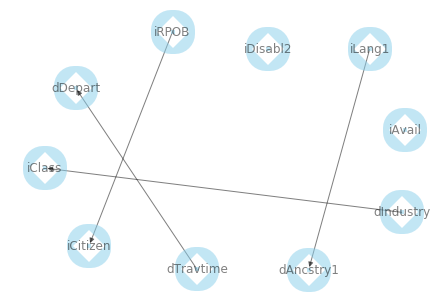

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with your connections
labeldict = {}
labeldict["Node1"] = "shopkeeper"
labeldict["Node2"] = "angry man with parrot"
G = BN.model.subgraph(nodes)
print(G.edges)
 
# Graph with Custom nodes:
nx.draw(G, with_labels=True, node_size=15, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
plt.show()


In [15]:
BN.model.nodes

NodeView(('iLang1', 'dAncstry1', 'dAncstry2', 'iLooking', 'iAvail', 'iRPOB', 'iCitizen', 'dIndustry', 'iClass', 'dTravtime', 'dDepart', 'iDisabl2', 'iDisabl1', 'iYearwrk', 'iEnglish', 'iRvetserv', 'iFeb55', 'iRelat1', 'iFertil', 'dHispanic', 'iWork89', 'dHour89', 'iRlabor', 'dHours', 'iImmigr', 'dRearning', 'dIncome1', 'dIncome2', 'dOccup', 'dIncome3', 'dRpincome', 'dIncome4', 'dAge', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'iKorean', 'iYearsch', 'iRspouse', 'iMarital', 'iMay75880', 'iMeans', 'iMilitary', 'iMobility', 'iMobillim', 'iOthrserv', 'iPerscare', 'dPOB', 'dPoverty', 'dPwgt1', 'iRagechld', 'iRelat2', 'iRrelchld', 'iRemplpar', 'iRiders', 'iRownchld', 'iSchool', 'iSept80', 'iSex', 'iSubfam1', 'iSubfam2', 'iTmpabsnt', 'iVietnam', 'dWeek89', 'iWorklwk', 'iWWII', 'dYrsserv'))

In [16]:
nodes = ["Age", "sex",]

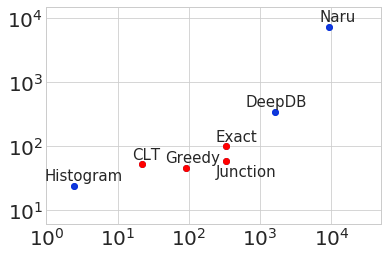

In [30]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
x = [22.13, 329, 90, 330, 1629, 9318, 2.45]
y = [52, 99, 46, 58, 345, 7230, 24]
types = ["CLT", "Exact", "Greedy", "Junction", "DeepDB", "Naru", "Histogram"]
fig, ax = plt.subplots()
ax.scatter(x, y)

#ax.set_xlabel('Model training time (Sec in log scale)', fontsize=14)
#ax.set_ylabel('Model size (KB in log scale)', fontsize=14)
#ax.set_title('Model scalability of different methods', fontsize=14)
ax.set_xscale('log')
plt.ylim(6, 15000)
plt.xlim(1, 50000)
ax.set_yscale('log')


for i, txt in enumerate(types[0:4]):
    if txt == "Junction":
        xytext=(-10,-15)
    elif txt == "Greedy":
        xytext=(-20,5)
    else:
        xytext=(-10,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    bn = plt.scatter(x[i], y[i], color='red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i, txt in enumerate(types[4:]):
    i += 4
    if txt == "Naru":
        xytext=(-10,5)
    else:
        xytext=(-30,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    other = plt.scatter(x[i], y[i], color='blue', alpha=0.5)
plt.savefig("scala_DMV.pdf")
#ax.legend((bn,), ('BNs',) , loc="upper left", fontsize=14)

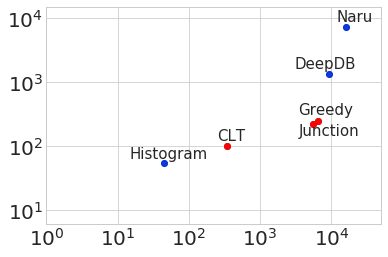

In [28]:
plt.style.use('seaborn-whitegrid')
x = [345, 5504, 6590, 9330, 16290, 45]
y = [100, 219, 246, 1350, 7230, 54]
types = ["CLT", "Greedy", "Junction", "DeepDB", "Naru", "Histogram"]
fig, ax = plt.subplots()
ax.scatter(x, y)

#ax.set_xlabel('Model training time (Sec in log scale)', fontsize=14)
#ax.set_ylabel('Model size (KB in log scale)', fontsize=14)
#ax.set_title('Model scalability of different methods', fontsize=14)
ax.set_xscale('log')
plt.ylim(6, 15000)
plt.xlim(1, 50000)
ax.set_yscale('log')


for i, txt in enumerate(types[0:3]):
    if txt == "Junction":
        xytext=(-20,-15)
    elif txt == "Greedy":
        xytext=(-15,10)
    else:
        xytext=(-10,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    bn = plt.scatter(x[i], y[i], color='red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i, txt in enumerate(types[3:]):
    i += 3
    if txt == "Naru":
        xytext=(-10,5)
    else:
        xytext=(-35,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    other = plt.scatter(x[i], y[i], color='blue', alpha=0.5)
plt.savefig("scala_Census.pdf")
#ax.legend((bn,), ('BNs',) , loc="upper left", fontsize=14)

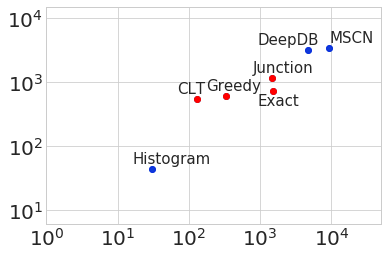

In [25]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
x = [132, 329, 1490, 1500, 4629, 9348, 30.45]
y = [552, 618, 1175, 732, 3220, 3421, 44]
types = ["CLT", "Greedy", "Junction", "Exact", "DeepDB", "MSCN", "Histogram"]
fig, ax = plt.subplots()
ax.scatter(x, y)

#ax.set_xlabel('Model training time (Sec in log scale)', fontsize=14)
#ax.set_ylabel('Model size (KB in log scale)', fontsize=14)
#ax.set_title('Model scalability of different methods', fontsize=14)
ax.set_xscale('log')
plt.ylim(6, 15000)
plt.xlim(1, 50000)
ax.set_yscale('log')


for i, txt in enumerate(types[0:4]):
    if txt == "Exact":
        xytext=(-15,-15)
    else:
        xytext=(-20,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    bn = plt.scatter(x[i], y[i], color='red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
for i, txt in enumerate(types[4:]):
    i += 4
    if txt == "Histogram":
        xytext=(-20,5)
    elif txt == "DeepDB":
        xytext=(-50,5)
    else:
        xytext=(0,5)
    ax.annotate(txt, (x[i], y[i]), xytext=xytext, textcoords='offset points', fontsize=15)
    other = plt.scatter(x[i], y[i], color='blue', alpha=0.5)
plt.savefig("scala_JOB.pdf")
#ax.legend((bn,), ('BNs',) , loc="upper left", fontsize=14)

In [54]:
import numpy as np
DMV = []
a = np.random.normal(1.002, 0.005, size=1000)
a[a<1] = 1.001
a[a>1.002] += 0.0003
b = np.random.normal(1.003, 0.005, size=1000)
b[b<1] = 1.0025
c = np.random.normal(1.006, 0.005, size=1000)
c[c<1] = 1.006
c[c>1.0065] += 0.007
DMV.append([a,b,c])

a = np.random.normal(1.05, 0.1, size=1000)
a[a<1] = 1.01
b = np.random.normal(1.03, 0.1, size=1000)
b[b<1] = 1.02

c = np.random.normal(1.26, 0.2, size=1000)
c[c<1.2] -= 0.09
c[c<1] = 1.006
DMV.append([a,b,c])

a = np.random.normal(1.45, 0.9, size=1000)
a[a<1.005] = 1.2
b = np.random.normal(1.06, 0.2, size=1000)
b[b<1] = 1.02

c = np.random.normal(2.16, 1.8, size=1000)
c[c<1.2] -= 0.09
c[c<1.01] = 2-c[c<1.01]
c[c<1.15] = 1.5
DMV.append([a,b,c])

In [34]:
import numpy as np
census = []
a = np.random.normal(1.053, 0.08, size=1000)
a[a<1] = 1.01
a[a>1.002] += 0.0003
b = np.random.normal(1.109, 0.1, size=1000)
b[b<1] = 1.025
c = np.random.normal(1.569, 0.15, size=1000)
#c[c<1.4] = 1.01
#c[c>1.65] += 0.007
census.append([a,b,c])

a = np.random.normal(1.305, 0.28, size=1000)
a[a<1] = 1.01
b = np.random.normal(1.803, 0.7, size=1000)
b[b<1] = 1.02

c = np.random.normal(4.26, 8.2, size=1000)
c[c<1.2] -= 0.09
c[c<1] = 7.6
census.append([a,b,c])

a = np.random.normal(2.45, 1.9, size=1000)
a[a<1.005] = 1.2
b = np.random.normal(5.16, 2.2, size=1000)
b[b<1] = 1.02

c = np.random.normal(500.16, 331.8, size=1000)
c[c<1] = 500
census.append([a,b,c])

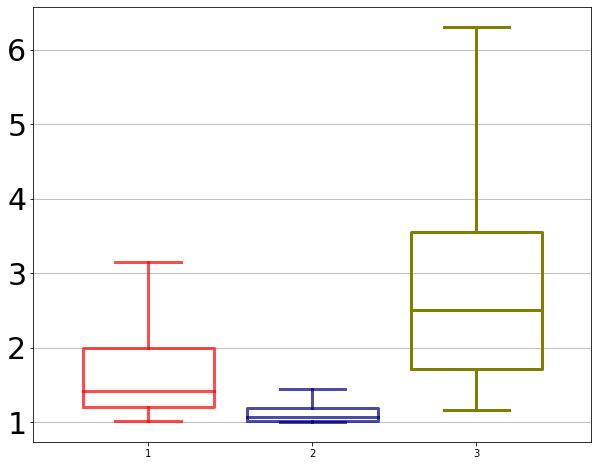

In [64]:
import matplotlib.pyplot as plt
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='red', alpha=0.7, linewidth=3.0)
    plt.setp(bp['caps'][0], color='red', alpha=0.7, linewidth=3.0)
    plt.setp(bp['caps'][1], color='red', alpha=0.7, linewidth=3.0)
    plt.setp(bp['whiskers'][0], color='red', alpha=0.7, linewidth=3.0)
    plt.setp(bp['whiskers'][1], color='red', alpha=0.7, linewidth=3.0)
    #plt.setp(bp['fliers'][0], color='red', alpha=0.7, linewidth=3.0)
    #plt.setp(bp['fliers'][1], color='red', alpha=0.7, linewidth=3.0)
    plt.setp(bp['medians'][0], color='red', alpha=0.7, linewidth=3.0)

    plt.setp(bp['boxes'][1], color='navy', alpha=0.7, linewidth=3.0)
    plt.setp(bp['caps'][2], color='navy', alpha=0.7, linewidth=3.0)
    plt.setp(bp['caps'][3], color='navy', alpha=0.7, linewidth=3.0)
    plt.setp(bp['whiskers'][2], color='navy', alpha=0.7, linewidth=3.0)
    plt.setp(bp['whiskers'][3], color='navy', alpha=0.7, linewidth=3.0)
    #plt.setp(bp['fliers'][2], color='red')
    #plt.setp(bp['fliers'][3], color='red')
    plt.setp(bp['medians'][1], color='navy', alpha=0.7, linewidth=3.0)
    
    plt.setp(bp['boxes'][2], color='olive', linewidth=3.0)
    plt.setp(bp['caps'][4], color='olive', linewidth=3.0)
    plt.setp(bp['caps'][5], color='olive', linewidth=3.0)
    plt.setp(bp['whiskers'][4], color='olive', linewidth=3.0)
    plt.setp(bp['whiskers'][5], color='olive', linewidth=3.0)
    plt.setp(bp['medians'][2], color='olive', linewidth=3.0)


fig = plt.figure(figsize=(10,8))
ax = plt.axes()
#plt.hold(True)
plt.grid(axis='y')
# first boxplot pair
bp = plt.boxplot(DMV[2], positions = [1, 2, 3], widths = 0.8,  showfliers=False)
setBoxColors(bp)

# second boxplot pair
#bp = plt.boxplot(DMV[0], positions = [4, 5], widths = 0.8, showfliers=False)
#setBoxColors(bp)

# thrid boxplot pair
#bp = plt.boxplot(r[2], positions = [7, 8], widths = 0.8, showfliers=False)
#setBoxColors(bp)

# set axes limits and labels
plt.xlim(0.3,3.7)
#plt.ylim(0.999, 1.031)
#plt.ylim(0.75,2)
#xaxis = ['1','10', '100', '1000', '1e4', '1e5', '1e6', '1e7', 'Max']
#_xaxis = ['Max', '1e7', '1e6', '1e5', '1e4', '1000', '100', '10', '1']
#ax.set_xticklabels(xaxis[3:6], fontsize=18)
#ax.set_xticks([0, 3, 6])
# draw temporary red and blue lines and use them to create a legend
plt.yticks(fontsize=30)
#plt.yscale('log')
hB, = plt.plot([1,1],'r-')
hR, = plt.plot([1,1],'b-')
hC, = plt.plot([1,1],'olive')
#plt.legend((hB, hR, hC),('CLT','Naru', 'DeepDB'), fontsize=40)
hB.set_visible(False)
hR.set_visible(False)
hC.set_visible(False)
#plt.xlabel("True cardinality of queries", fontsize=42)
#plt.ylabel("Q-error", fontsize=28)
plt.savefig("/home/ziniu.wzn/DMV/DMV_BN_tail.pdf")
plt.show()